# Priority Model Training Notebook
This notebook covers the end-to-end process for building an AI-driven order prioritization model, including data loading, preprocessing, model training, evaluation, and explainability.

## 1. Import Required Libraries
Import libraries such as pandas, numpy, scikit-learn, matplotlib, seaborn, and SHAP.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import joblib

## 2. Load and Explore Dataset
Load the dataset from orders.csv and perform basic exploratory data analysis (EDA) to understand its structure.

In [25]:
# Load the dataset
orders = pd.read_csv('orders.csv')

# Display the first few rows
display(orders.head())

# Show basic info
orders.info()

# Describe numerical features
orders.describe()

# Check for missing values
orders.isnull().sum()

,order_id,customer_id,customer_segment,order_date,due_date,product_type,quantity,estimated_production_time,resource_available,machine_id,status,priority_score
0,O10000,C1328,B,2025-05-29,2025-06-05,Doohickey,52,19.07,11,M5,delayed,3.29
1,O10001,C1058,B,2025-06-27,2025-07-11,Thingamajig,93,19.18,9,M3,queued,0.48
2,O10002,C1013,B,2025-07-01,2025-07-06,Thingamajig,15,4.43,11,M2,in progress,5.56
3,O10003,C1380,B,2025-06-27,2025-07-09,Thingamajig,72,20.94,5,M5,in progress,1.11
4,O10004,C1141,B,2025-06-01,2025-06-07,Widget,61,17.03,6,M3,queued,3.90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_id                   2500 non-null   object 
 1   customer_id                2500 non-null   object 
 2   customer_segment           2500 non-null   object 
 3   order_date                 2500 non-null   object 
 4   due_date                   2500 non-null   object 
 5   product_type               2500 non-null   object 
 6   quantity                   2500 non-null   int64  
 7   estimated_production_time  2500 non-null   float64
 8   resource_available         2500 non-null   int64  
 9   machine_id                 2500 non-null   object 
 10  status                     2500 non-null   object 
 11  priority_score             2500 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 234.5+ KB


order_id                     0
customer_id                  0
customer_segment             0
order_date                   0
due_date                     0
product_type                 0
quantity                     0
estimated_production_time    0
resource_available           0
machine_id                   0
status                       0
priority_score               0
dtype: int64

## 3. Feature Engineering
Engineer priority-related features to improve model performance.

In [26]:
# Feature Engineering Example (using only relevant columns from the dataset)

# Calculate days until due date
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['due_date'] = pd.to_datetime(orders['due_date'])
orders['days_to_due'] = (orders['due_date'] - orders['order_date']).dt.days

# Production load per resource (quantity / resource_available)
orders['production_load'] = orders['quantity'] / (orders['resource_available'] + 1)

# Urgency score (days to due divided by estimated production time)
orders['urgency_score'] = orders['days_to_due'] / (orders['estimated_production_time'] + 1e-3)

# Is delayed (binary feature)
orders['is_delayed'] = (orders['status'] == 'delayed').astype(int)

# Encode product type and customer segment as categorical codes
orders['product_type_code'] = orders['product_type'].astype('category').cat.codes
orders['customer_segment_code'] = orders['customer_segment'].astype('category').cat.codes

# Do NOT use order_id or customer_id as features
# You can add more features based on domain knowledge

In [27]:
display(orders.sample(5))

,order_id,customer_id,customer_segment,order_date,due_date,product_type,quantity,estimated_production_time,resource_available,machine_id,status,priority_score,days_to_due,production_load,urgency_score,is_delayed,product_type_code,customer_segment_code
1764,O11764,C1005,B,2025-05-20,2025-05-22,Gadget,6,2.03,9,M5,delayed,7.00,2,0.600000,0.984737,1,1,1
597,O10597,C1461,B,2025-06-29,2025-07-01,Gadget,37,8.59,6,M3,in progress,6.34,2,5.285714,0.232802,0,1,1
2476,O12476,C1089,A,2025-06-03,2025-06-09,Doohickey,90,20.77,8,M4,in progress,5.52,6,10.000000,0.288864,0,0,0
2141,O12141,C1031,A,2025-05-23,2025-05-26,Doohickey,89,32.96,7,M5,queued,5.50,3,11.125000,0.091017,0,0,0
1193,O11193,C1114,B,2025-05-27,2025-06-10,Doohickey,45,16.60,10,M3,queued,0.74,14,4.090909,0.843323,0,0,1


## 3. Preprocess Data
Clean and preprocess the data, including handling missing values, encoding categorical variables, and feature scaling.

In [28]:
# Data Preprocessing Example
# Fill missing values (customize as needed)
orders = orders.fillna(method='ffill')

# List of columns to exclude from preprocessing
exclude_cols = ['order_id', 'customer_id', 'order_date', 'due_date', 'priority_score']

# Encode categorical variables (excluding IDs and dates), create new columns for encoded features
categorical_cols = [col for col in orders.select_dtypes(include=['object', 'category']).columns if col not in exclude_cols]
for col in categorical_cols:
    orders[col + '_enc'] = LabelEncoder().fit_transform(orders[col])

# Feature scaling (scale only original numeric feature columns, exclude IDs, dates, target, and encoded columns)
numeric_cols = [col for col in orders.columns if orders[col].dtype in ['int64', 'float64'] and col not in exclude_cols and not col.endswith('_enc')]
scaler = StandardScaler()
scaled = scaler.fit_transform(orders[numeric_cols])
for i, col in enumerate(numeric_cols):
    orders[col + '_scaled'] = scaled[:, i]

# All original columns are preserved; encoded and scaled features are in new columns

C:\Users\pranj\AppData\Local\Temp\ipykernel_22844\624000478.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  orders = orders.fillna(method='ffill')


In [35]:
display(orders.head())
print(orders.columns)
print(orders.info())
print(orders.iloc[:, 7:20])  # Display first 10 columns for brevity

,order_id,customer_id,customer_segment,order_date,due_date,product_type,quantity,estimated_production_time,resource_available,machine_id,...,customer_segment_enc,product_type_enc,machine_id_enc,status_enc,quantity_scaled,estimated_production_time_scaled,resource_available_scaled,days_to_due_scaled,production_load_scaled,urgency_score_scaled
0,O10000,C1328,B,2025-05-29,2025-06-05,Doohickey,52,19.07,11,M5,...,1,0,4,0,0.088677,0.622136,1.556399,-0.275604,-0.467918,-0.288933
1,O10001,C1058,B,2025-06-27,2025-07-11,Thingamajig,93,19.18,9,M3,...,1,2,2,2,1.505135,0.634421,0.672985,1.601077,0.694970,-0.217303
2,O10002,C1013,B,2025-07-01,2025-07-06,Thingamajig,15,4.43,11,M2,...,1,2,1,1,-1.189589,-1.012812,1.556399,-0.811799,-1.189845,-0.138629
3,O10003,C1380,B,2025-06-27,2025-07-09,Thingamajig,72,20.94,5,M5,...,1,2,4,1,0.779632,0.830972,-1.093843,1.064883,1.327144,-0.248268
4,O10004,C1141,B,2025-06-01,2025-06-07,Widget,61,17.03,6,M3,...,1,3,2,2,0.399607,0.394316,-0.652136,-0.543701,0.557832,-0.291845


Index(['order_id', 'customer_id', 'customer_segment', 'order_date', 'due_date',
       'product_type', 'quantity', 'estimated_production_time',
       'resource_available', 'machine_id', 'status', 'priority_score',
       'days_to_due', 'production_load', 'urgency_score', 'is_delayed',
       'product_type_code', 'customer_segment_code', 'customer_segment_enc',
       'product_type_enc', 'machine_id_enc', 'status_enc', 'quantity_scaled',
       'estimated_production_time_scaled', 'resource_available_scaled',
       'days_to_due_scaled', 'production_load_scaled', 'urgency_score_scaled'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   order_id                          2500 non-null   object        
 1   customer_id                       2500 non-null   object      

## 4. Split Data into Training and Test Sets
Use scikit-learn's train_test_split to divide the data into training and test sets.

In [ ]:
# # Select only relevant features for modeling (use encoded and scaled columns as appropriate)
# relevant_features = [
#     'quantity_scaled',
#     'product_type_enc',
#     'customer_segment_enc',
#     'machine_id_enc',
#     'status_enc',
#     'days_to_due_scaled',
#     'production_load_scaled',
#     'urgency_score_scaled',
#     'is_delayed'
# ]

# X = orders[relevant_features]
# y = orders['priority_score']

# # Split into train and test sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Temporal Train-Test Split
Split the data based on time (e.g., by order date) to avoid data leakage and better simulate real-world prediction.

In [41]:
# Temporal Train-Test Split Example (using only relevant features)
relevant_features = [
    'quantity_scaled',
    'product_type_enc',
    'customer_segment_enc',
    'machine_id_enc',
    'status_enc',
    'days_to_due_scaled',
    'production_load_scaled',
    'urgency_score_scaled',
    'is_delayed'
]

if 'order_date' in orders.columns:
    orders = orders.sort_values('order_date')
    split_date = orders['order_date'].quantile(0.8)
    train = orders[orders['order_date'] <= split_date]
    test = orders[orders['order_date'] > split_date]
    X_train = train[relevant_features]
    y_train = train['priority_score']
    X_test = test[relevant_features]
    y_test = test['priority_score']
else:
    print('order_date column not found, using random split as fallback.')

## 5. Define Priority Model Architecture
Define the architecture of the priority model using a machine learning framework (RandomForestClassifier as an example).

In [44]:
# Define the priority model (Random Forest Regressor for continuous target)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

## 6. Train the Priority Model
Train the model on the training data and monitor training metrics.

In [45]:
# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 7. Evaluate Model Performance
Evaluate the trained model on the test set using appropriate metrics.

In [47]:
# Evaluate model performance (regression metrics)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
preds = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds))
print('MSE:', mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))
print('R2 Score:', r2_score(y_test, preds))

MAE: 0.10667274633123693
MSE: 0.02627622966457019
RMSE: 0.1620994437515755
R2 Score: 0.9944110517207436


## 9. SHAP Analysis
Use SHAP to explain feature contributions to the model's predictions.

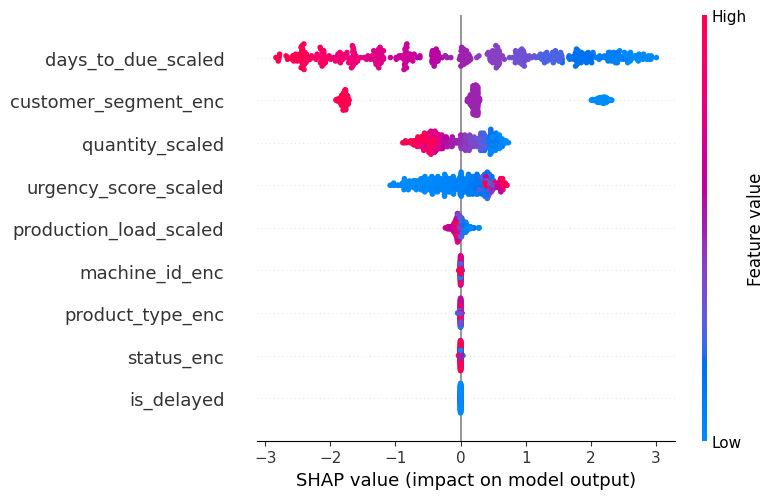

In [48]:
# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)

## 8. Save Trained Model
Save the trained model to disk for later use.

In [49]:
# Save the trained model
joblib.dump(model, 'priority_model.joblib')

['priority_model.joblib']

In [50]:
# Save encoders and scaler for future use after fitting on training data
from preprocessing import save_preprocessing_artifacts
save_preprocessing_artifacts()
print('Encoders and scaler saved!')

Encoders and scaler saved!
